<a href="https://colab.research.google.com/github/lmarieta/FaceRecognition/blob/main/Face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before starting, upload data.RData, data_submission.RData, IdLookupTable.csv files. After training your model, you can download it. After saving the output file, you can also download it.

Import Libraries


In [ ]:
import numpy as np
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
#from sklearn import train_test_split
import matplotlib.pyplot as plt
!pip install pyreadr
import pyreadr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 6.5 MB/s eta 0:00:00


Load data

In [ ]:
filename = '/content/data.RData'
df = pyreadr.read_r(filename)
# Some checks
print(df['d.train'].columns)
print(df['d.test'].columns)
print(df['d.train'].count())
print(df['d.test'].count())
print(df['im.train'].head())
print(df['im.test'].head())
print(df['d.train'].shape)
print(df['d.test'].shape)
print(df['im.train'].shape)
print(df['im.test'].shape)
x_train = df['im.train']
y_train = df['d.train']
x_test = df['im.test']
y_test = df['d.test']
# Get the indices of rows containing NaN values. Note that train and test splits are random with a given seed.
nan_indices_train = x_train.index[x_train.isnull().any(axis=1)].tolist() + y_train.index[y_train.isnull().any(axis=1)].tolist()
nan_indices_test = x_test.index[x_test.isnull().any(axis=1)].tolist() + y_test.index[y_test.isnull().any(axis=1)].tolist()

# Drop rows containing NaN values
x_train = x_train.drop(x_train.index[nan_indices_train])
y_train = y_train.drop(y_train.index[nan_indices_train])
x_test = x_test.drop(x_test.index[nan_indices_test])
y_test = y_test.drop(y_test.index[nan_indices_test])

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')
Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inn

Single layer model

In [ ]:
# Define the model (two hidden layers)
pixel_num = x_train.shape[1]
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(pixel_num,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(y_train.shape[1])  # Output layer with 2 units per keypoint (x and y coordinates)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(x_train, y_train, epochs=400, batch_size=32)

# Make predictions
predictions = model.predict(x_test)

# Size of the image is given, prediction cannot be outside of range
min_value = 0
max_value = 96
constrained_predictions = np.clip(predictions, min_value, max_value)

# Save the model to a file
model.save('/content/simple_model.h5')

Epoch 1/400
55/55 [==============================] - 1s 8ms/step - loss: 8590.8252
Epoch 2/400
55/55 [==============================] - 0s 9ms/step - loss: 1118.1140
Epoch 3/400
55/55 [==============================] - 0s 7ms/step - loss: 345.8312
Epoch 4/400
55/55 [==============================] - 0s 7ms/step - loss: 177.7047
Epoch 5/400
55/55 [==============================] - 0s 7ms/step - loss: 167.1281
Epoch 6/400
55/55 [==============================] - 0s 7ms/step - loss: 146.0612
Epoch 7/400
55/55 [==============================] - 1s 11ms/step - loss: 179.9760
Epoch 8/400
55/55 [==============================] - 1s 14ms/step - loss: 142.6738
Epoch 9/400
55/55 [==============================] - 1s 15ms/step - loss: 126.1997
Epoch 10/400
55/55 [==============================] - 1s 13ms/step - loss: 122.3596
Epoch 11/400
55/55 [==============================] - 1s 13ms/step - loss: 112.1662
Epoch 12/400
55/55 [==============================] - 1s 10ms/step - loss: 120.6359
Epoch

In [ ]:
# First, calculate the column means along axis 0 (columns)
col_means = np.nanmean(y_train, axis=0)

# Next, create the matrix 'p' using the calculated column means
num_rows_d_test = y_test.shape[0]
num_cols_d_train = y_train.shape[1]

# Create the matrix 'p' with the specified dimensions and fill it with column means
p = np.tile(col_means, (num_rows_d_test, 1)).astype(y_train.dtypes)

# Compute RMSE
rmse = np.sqrt(np.nanmean((y_test - p) ** 2))

# Print RMSE
print('RMSE : ')
print(rmse)

RMSE : 
3.1191622311668468


In [ ]:
df_predictions = pd.DataFrame(predictions)

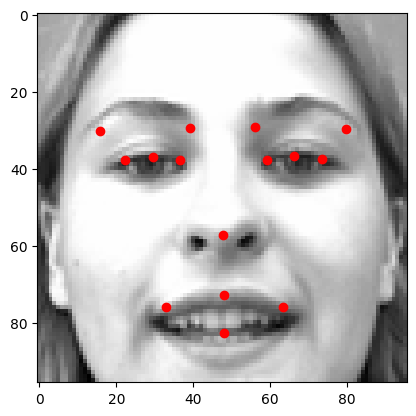

In [ ]:
# Plot the first image in the DataFrame
image = np.array(x_test.iloc[1,:])  # Convert the Series to a NumPy array
image = image.reshape((96, 96))  # Reshape the array to the desired image dimensions
predicted_keypoints = predictions[1].reshape((15, 2))
plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='r', marker='o')
plt.imshow(image, cmap='gray')
plt.show()

56/56 [==============================] - 0s 4ms/step


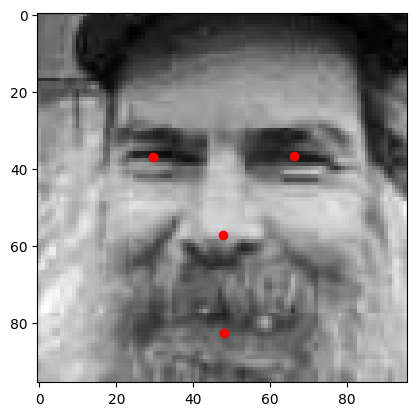

In [ ]:
from pandas.io.parsers.readers import read_csv
# Extract data for output
filename = '/content/data_submission.RData'
df_submission = pyreadr.read_r(filename)
x_submission = df_submission['im_submission']
# Get the indices of rows containing NaN values.
nan_indices_submission = x_submission.index[x_submission.isnull().any(axis=1)].tolist()
# Drop rows containing NaN values
x_submission = x_submission.drop(x_submission.index[nan_indices_submission])

# Make predictions
predictions_submission = model.predict(x_submission)

# Size of the image is given, prediction cannot be outside of range
min_value = 0
max_value = 96
constrained_predictions_submission = np.clip(predictions_submission, min_value, max_value)

# Remove predictions not requested in IdLookupTable.csv
filename = '/content/IdLookupTable.csv'
IdLookupTable = read_csv(filename)
# All keypoints names
keypoints_names = IdLookupTable['FeatureName'].iloc[0:30]
# Calculate the repeating sequence based on the number of rows in 'df'
repeating_sequence = np.repeat(np.arange(1, 1783*30 // 30 + 1), 30)
# Add the repeating sequence as a new column to the DataFrame
keypoints_names_filter = pd.DataFrame({'ImageId': repeating_sequence})
keypoints_names_filter['Indices'] = range(len(keypoints_names_filter))
keypoints_names_filter['FeatureName'] = pd.concat([keypoints_names] * 1783, ignore_index=True)
# Filter
keypoints_names_filter = keypoints_names_filter.merge(IdLookupTable[['ImageId', 'FeatureName']], on=['ImageId', 'FeatureName'], how='inner')
# Create a mask of size 1783x30 where True indicates the indices to keep
nb_output_images = x_submission.shape[0]
mask = np.isin(np.arange(nb_output_images*30), keypoints_names_filter['Indices'])
# Reshape the mask to the same shape as 'np_array'
mask = mask.reshape(constrained_predictions_submission.shape)
# Use the mask to replace values in the NumPy array with NaN
constrained_predictions_submission[~mask] = np.nan

# Plot the first image in the DataFrame
image = np.array(x_submission.iloc[-1,:])  # Convert the Series to a NumPy array
image = image.reshape((96, 96))  # Reshape the array to the desired image dimensions
predicted_keypoints = constrained_predictions_submission[-1].reshape((15, 2))
plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='r', marker='o')
plt.imshow(image, cmap='gray')
plt.show()

# Prepare for output file
df_predictions = pd.DataFrame(constrained_predictions_submission)

# Convert the DataFrame to a NumPy array and reshape it
reshaped_values = df_predictions.values.reshape(-1, 1)

# Remove NaN values from the NumPy array
reshaped_values = reshaped_values[~np.isnan(reshaped_values)]

# Create a new DataFrame with the reshaped values
reshaped_df = pd.DataFrame(reshaped_values, columns=['Value'])
indices = pd.DataFrame(range(1,len(reshaped_df)+1))
submission = pd.concat([indices, reshaped_df], axis=1)
submission.rename(columns={0: 'RowId','Value': 'Location'}, inplace=True)

# Write to csv file
submission.to_csv('/content/simple_model_submission.csv',index=False)
